# Grad-CAM experiments

Contributions of different portions of an album cover towards it being classified as either "popular" or "rock".

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
# !curl https://course-v3.fast.ai/setup/colab | bash

In [0]:
# !apt-get -qq install ffmpeg
# restart kernel after install

In [0]:
# DRIVE_BASE_PATH = "/content/gdrive/My\ Drive/Colab\ Notebooks/"

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from fastai import *
from fastai.vision import *

In [4]:
from fastai import version as fastai_version

In [5]:
print(f'fastai version -> {fastai_version.__version__}')

fastai version -> 1.0.33


In [3]:
bs = 32  #batch size

In [4]:
path = Path('../../../album-art-genre-classifier/local_only_data/exp4/')

In [5]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [6]:
tfms = get_transforms(do_flip=False)

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([\d]+).jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [8]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.08,
        ds_tfms=get_transforms(do_flip=False, max_rotate=0.2, max_warp=0.2), 
                                  size=224, num_workers=4, bs=bs).normalize(imagenet_stats)

In [10]:
data.classes

['popular', 'rock']

In [11]:
learn = create_cnn(data, models.resnet50, pretrained=False)

In [12]:
learn.load('exp-4-stage-2-v2');

### Test images containing objects belonging to 2 classes

In [22]:
test_data ={
    "rock": [
        "https://upload.wikimedia.org/wikipedia/en/thumb/b/b2/Metallica_-_Master_of_Puppets_cover.jpg/220px-Metallica_-_Master_of_Puppets_cover.jpg",
        "https://i.pinimg.com/originals/c4/7c/26/c47c266343fe9b13e75a7e95efe9e96e.jpg",
        "https://66.media.tumblr.com/3e3e27b913b47453d1274cccbc9c8bda/tumblr_nobgh86B6i1tu537lo1_500.jpg",
        "https://www.billboard.com/files/styles/900_wide/public/media/Green-Day-American-Idiot-album-covers-billboard-1000x1000.jpg",
        "https://www.billboard.com/files/styles/900_wide/public/media/Judas-Priest-British-Steel-album-covers-billboard-1000x1000.jpg",
        "https://www.udiscovermusic.com/wp-content/uploads/2017/08/Beatles-Sgt-Pepper-Cover.jpg",
        "https://metalodyssey.files.wordpress.com/2015/05/iron-maiden-seventh-son-of-a-seventh-son-promo-album-cover-pic-1988-339988immo.jpg",
        "https://reverb-res.cloudinary.com/image/upload/c_scale,w_500/v1415373025/reeves-hendrix-630-80_luaf98.jpg",
        "http://www.liketotally80s.com/wp-content/uploads/2014/08/iron-maiden-killers-album.jpg"
        ],
                    
    "popular": [
        "https://www.billboard.com/files/styles/900_wide/public/media/06-taylor-swift-reputation-album-art-2017-billboard-1240.jpg",
        "https://i.pinimg.com/originals/26/eb/e9/26ebe9788b358c734a2851048d05b12c.jpg",
        "http://artsfuse.org/wp-content/uploads/2011/04/Adele-21-Album-Cover-Art-500x500-300x300.png",
        "https://directlyrics.com/img/upload/ariana-grande-yours-truly-official-album-cover.jpg"
        ]
}

In [112]:
!mkdir local_only_test_data

In [108]:
for class_name in data.classes:
    for i, el in enumerate(test_data[class_name]):
        print(f'wget -q "{el}" -O local_only_test_data/{class_name}_{i}.jpg')
        !wget -q "{el}" -O test_pics/{class_name}_{i}.jpg

In [120]:
test_path = Path('local_only_test_data')

In [14]:
from math import ceil

In [127]:
def see_test_files(test_dir_path):
    test_files = test_dir_path.ls()
    
    num_cols = 4
    num_rows = ceil(len(test_files)/num_cols)
    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    for ind, ax in enumerate(ax.flat):
        if ind>=len(test_files):
            break   
            
        x = open_image(test_files[ind])
        xb,_ = data.one_item(x)
        xb_im = Image(data.denorm(xb)[0])
        xb_im.show(ax)
        title = test_files[ind].stem.split('_')[0]
        ax.set_title(title)
    
    fig.suptitle('Test images', fontsize=20)

    plt.show()

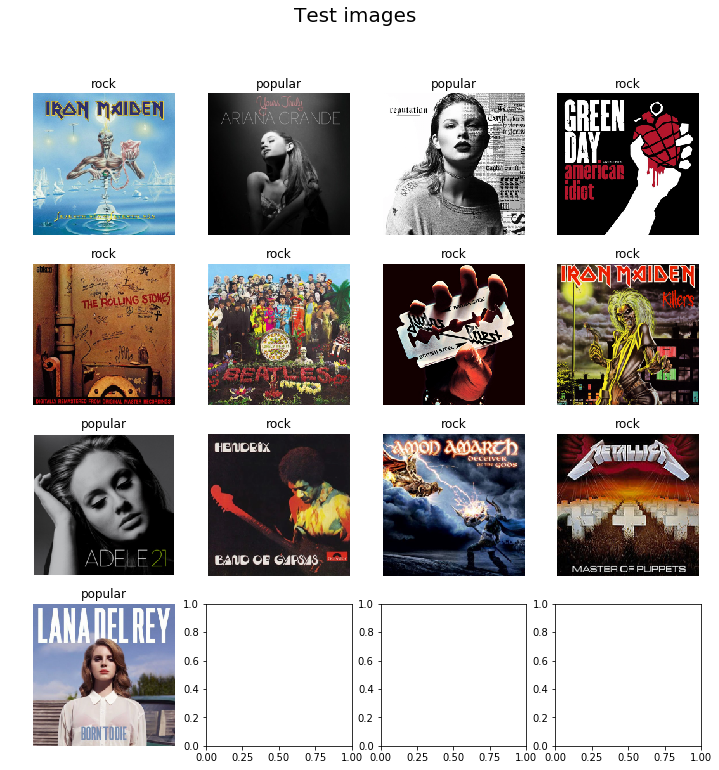

In [128]:
see_test_files(test_path)

In [25]:
from fastai.callbacks.hooks import *

In [27]:
m = learn.model.eval();

## Class-discriminative heat-maps along the network


In [47]:
def class_discriminative_activations(xb,cat):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [28]:
class_dict = {}
for i,el in enumerate(data.classes):
    class_dict[el.lower()] = i

In [57]:
def get_grad_cam_activations(xb, cat, relu=True):
    
    y = class_dict[cat]
    
    hooks_a,hooks_g = class_discriminative_activations(xb,y)
    
    acts = hooks_a.stored[0].cpu()
    grad = hooks_g.stored[0][0].cpu()

    grad_chan = grad.mean(1).mean(1)
    mult = (acts*grad_chan[...,None,None]).mean(0)

    if relu:
        mult = F.relu(mult)
            
    return mult

In [123]:
def plot_grad_cam_maps(img_paths):
    num_cols = len(data.classes)+1
    num_rows = len(img_paths)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)
    
    ind = 0
    
    for i in range(num_rows):
        x = open_image(img_paths[i])
        xb,_ = data.one_item(x)
        xb_im = Image(data.denorm(xb)[0])
        xb = xb.cuda()
        pred = learn.predict(x)[0]
        xb_im.show(ax[i,0])
        ax[i,0].set_title(f'predicted: {pred}')
        for j in range(1,num_cols):
            if ind>=len(img_paths*3):
                break

            mult = get_grad_cam_activations(xb, data.classes[j-1])
            xb_im.show(ax[i,j])
            ax[i,j].imshow(mult, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');
            ax[i,j].set_title(f'{data.classes[j-1]}')
            ind+=1

    fig.suptitle(f'Original/{" traits/".join(data.classes)} traits', fontsize=20)

The first column is the original images, the second highlights areas which contributed most towards "popular-cover" traits of the image, and the third towards the "rock-cover" traits.

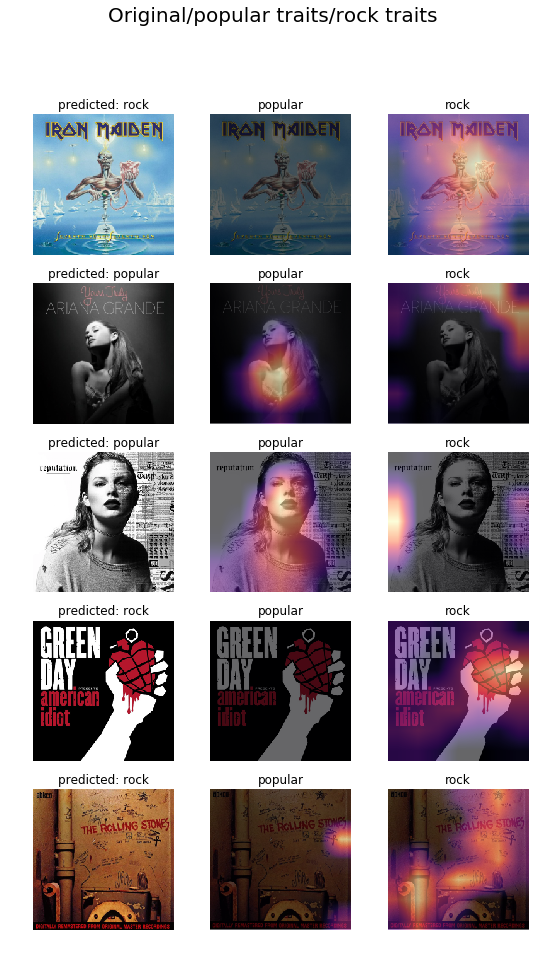

In [124]:
plot_grad_cam_maps(test_path.ls()[:5])

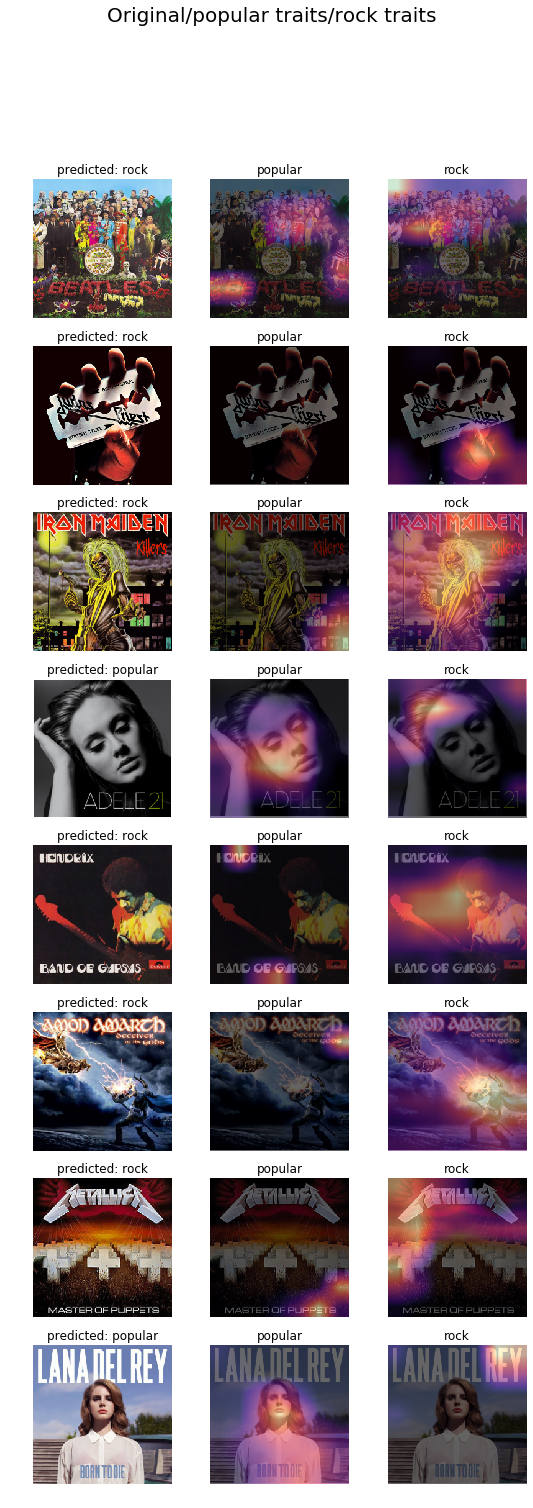

In [125]:
plot_grad_cam_maps(test_path.ls()[5:])

Fetching covers of somewhat obscure albums which the model hasn't seen before (most probably).

In [116]:
obscure_albums ={
    "rock": [
        "https://cloud.netlifyusercontent.com/assets/344dbf88-fdf9-42bb-adb4-46f01eedd629/1fc66b29-ccd1-4f2c-a23d-e034f41bfbf5/rushpowerwindows.jpg",
        "https://cloud.netlifyusercontent.com/assets/344dbf88-fdf9-42bb-adb4-46f01eedd629/8dcfbf97-483d-407a-8eb1-52e2ac568c93/crimsonking.jpg",
        "http://3.bp.blogspot.com/_vY8I5HvOvk8/STxJTvgWrEI/AAAAAAAAASA/Vsty5TdXVWk/s400/newsoftheworld.jpg",
        "http://hys2d3ayt6x6b7ts22ypg68p.wpengine.netdna-cdn.com/wp-content/uploads/2013/09/Hackamore-Brick.jpg",
        "https://img.discogs.com/hmkSYzgXQQukk73BKBLwYrJjsrs=/300x300/filters:strip_icc():format(jpeg):mode_rgb():quality(40)/discogs-images/R-5894729-1405632983-9914.jpeg.jpg",
        "https://farm1.static.flickr.com/195/499116142_092968cd64_b.jpg"
        ],
                    
    "popular": [
        "http://cps-static.rovicorp.com/3/JPG_400/MI0003/512/MI0003512453.jpg?partner=allrovi.com",
        "https://pbs.twimg.com/media/CITvoPHUEAAAe7_.jpg",
        "https://upload.wikimedia.org/wikipedia/en/thumb/6/6e/Little_Mix_-_Secret_Love_Song_%28Official_Single_Cover%29.png/220px-Little_Mix_-_Secret_Love_Song_%28Official_Single_Cover%29.png"
        ]
}
obscure_albums_path = "local_only_obscure_albums"

!mkdir {obscure_albums_path}

for class_name in data.classes:
    for i, el in enumerate(obscure_albums[class_name]):
        print(f'wget -q "{el}" -O {obscure_albums_path}/{class_name}_{i}.jpg')
        !wget -q "{el}" -O {obscure_albums_path}/{class_name}_{i}.jpg
        
obscure_albums_path = Path(obscure_albums_path)

wget -q "http://cps-static.rovicorp.com/3/JPG_400/MI0003/512/MI0003512453.jpg?partner=allrovi.com" -O local_only_obscure_albums/popular_0.jpg
wget -q "https://pbs.twimg.com/media/CITvoPHUEAAAe7_.jpg" -O local_only_obscure_albums/popular_1.jpg
wget -q "https://upload.wikimedia.org/wikipedia/en/thumb/6/6e/Little_Mix_-_Secret_Love_Song_%28Official_Single_Cover%29.png/220px-Little_Mix_-_Secret_Love_Song_%28Official_Single_Cover%29.png" -O local_only_obscure_albums/popular_2.jpg
wget -q "https://cloud.netlifyusercontent.com/assets/344dbf88-fdf9-42bb-adb4-46f01eedd629/1fc66b29-ccd1-4f2c-a23d-e034f41bfbf5/rushpowerwindows.jpg" -O local_only_obscure_albums/rock_0.jpg
wget -q "https://cloud.netlifyusercontent.com/assets/344dbf88-fdf9-42bb-adb4-46f01eedd629/8dcfbf97-483d-407a-8eb1-52e2ac568c93/crimsonking.jpg" -O local_only_obscure_albums/rock_1.jpg
wget -q "http://3.bp.blogspot.com/_vY8I5HvOvk8/STxJTvgWrEI/AAAAAAAAASA/Vsty5TdXVWk/s400/newsoftheworld.jpg" -O local_only_obscure_albums/rock_2.jpg


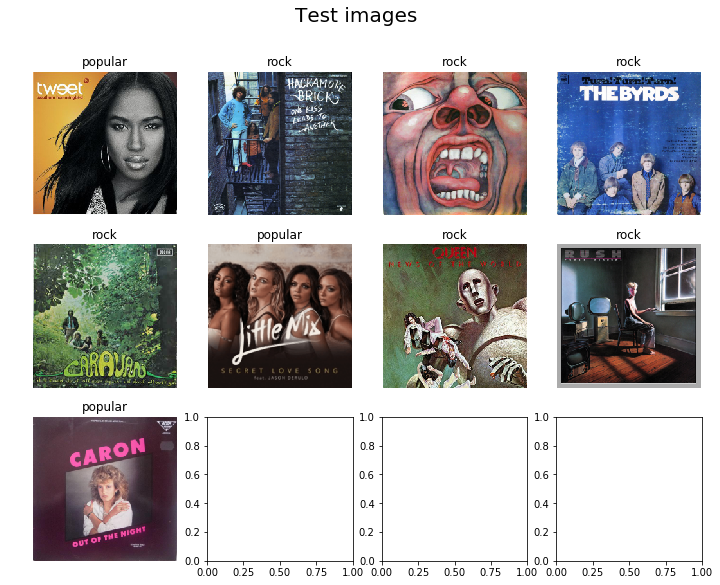

In [129]:
see_test_files(obscure_albums_path)

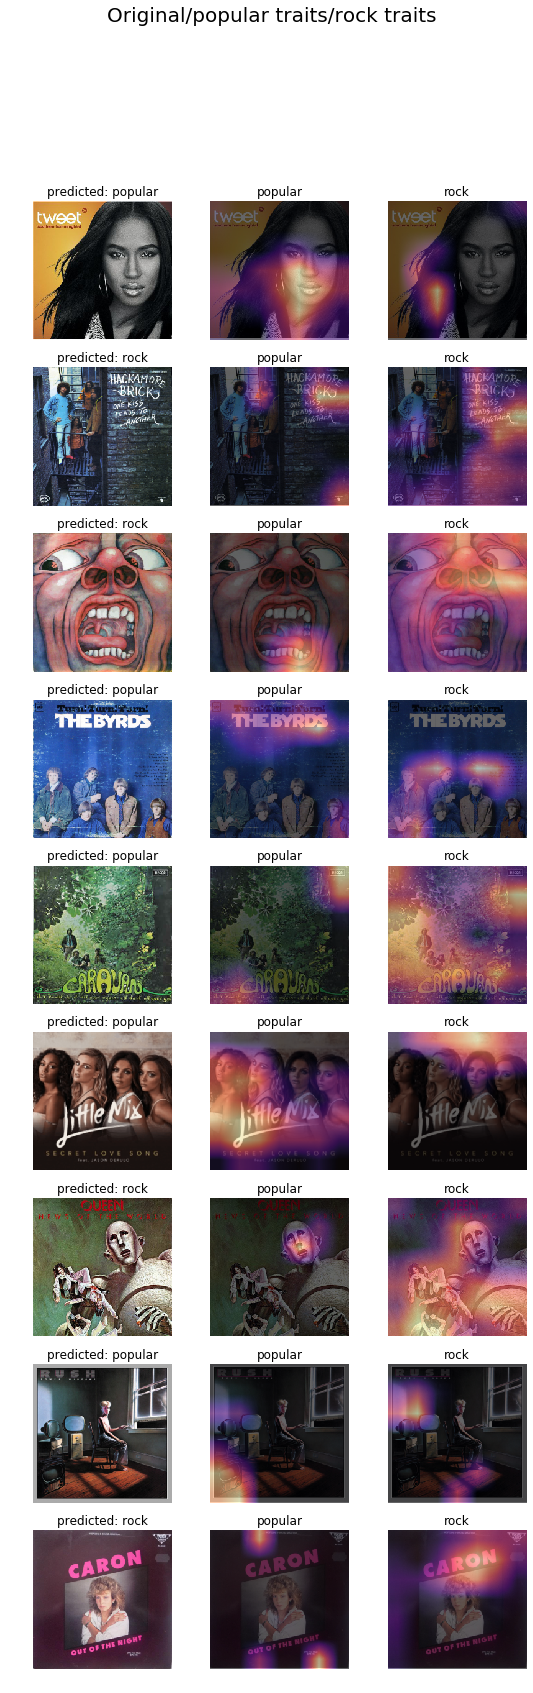

In [126]:
plot_grad_cam_maps(obscure_albums_path.ls())

That's interesting. In case of the Byrds the text is contributing most towards a "popular" score, whereas in case of Caron, it's contributing towards a "rock" score.

## References:
- [Grad-CAM:
Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
- [fastai's Deep Learning Part-1 (2018) MOOC](https://www.fast.ai/)